<font color=Brown>
    
Name: N S Ramanujam Mangena

<font color=Blue>
    
We were given a dataset which states who availed Term deposit from the previous campaign. Before we start with analyis, as an every data science project lets establish some basic understanding of the given problem statement.

Initial inference is just 11.7% of the members had availed Term deposit. This suggests that data is highly inbalanced. Now our aim is to build a model to predict the number of people who had actually taken Term deposit. Hence False negatives are vital for model performance and we concentrate on recall to measure the model's performance.

More over this is a classification problem as our target column is 'Target' which is categorical in nature. 1/0(True/False).
We use Ensemble methods to build predictive models.

In [1]:
#import basic libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns 
%matplotlib inline
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")

In [132]:
bank_df = pd.read_csv("bank-full.csv")
bank_df.shape

(45211, 17)

In [133]:
bank_df2 = bank_df.copy()

In [18]:
bank_df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome Target  
0  unknown    5   may       261         1     -1         0  unknown     no  
1  unknown    5   may       151         1     -1         0  unknown     no  
2  unknown    5   may        76         1     -1         0  unknown     no  
3  unknown    5   may        92         1     -1         0  unknown     no  
4  unknown    5   may       198         1     -1         0  unknown     no

In [72]:
sum(bank_df.duplicated())

0

Suggests no duplicate rows

In [122]:
bank_df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [123]:
bank_df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

suggests that no null vaalues or NaN rows in the dataset.

In [5]:
bank_df.describe()

age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

* Five point summary suggest that data is very screwed in all the contineous variables.
* pdays has many records with -1 which doesnt seem to be right.
* Many accounts have negative balances, could be overdraft accounts.

In [134]:
bank_df.skew().sort_values()

day          0.093079
age          0.684818
pdays        2.615715
duration     3.144318
campaign     4.898650
balance      8.360308
previous    41.846454
dtype: float64

Previous column is highly skewed.

In [135]:
bank_df[bank_df.pdays < 0].pdays.count()

36954

As its very high in quantity, We can consider absolute values of the column for pdays.

In [136]:
bank_df[bank_df.balance < 0].balance.count()

3766

We have 3766 members who have utilised overdraft account.

In [25]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null int32
marital      45211 non-null int32
education    45211 non-null int32
default      45211 non-null int32
balance      45211 non-null int64
housing      45211 non-null int32
loan         45211 non-null int32
contact      45211 non-null int32
day          45211 non-null int64
month        45211 non-null int32
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null int32
Target       45211 non-null int32
dtypes: int32(10), int64(7)
memory usage: 4.1 MB


Many columns have the object datatype which cant be used to perform any model building. We will later use Lable Encoder library to convert them to machine readable formats.

In [137]:
bank_df.drop(['duration'],axis =1,inplace = True)

This columns is dropped as it wouldnt be useful in building prediction models and problem statement advised us to ignore this colum as it could lead into inappropriate model building.

* Replacing negative pdays values with absolute values

In [138]:
bank_df['pdays'] = bank_df['pdays'].abs()

* Displaying the categorical columns summary and how  data is distributed for a quick reference.

In [139]:
#Drop duplicate records
bank_df.drop_duplicates(inplace =True)

In [140]:
sum(bank_df.duplicated())

0

In [21]:
bank_df2[['education','job','marital','default','housing','loan','contact','month','poutcome','Target']].apply(lambda x: x.value_counts()).T.stack()

education  primary           6851.0
           secondary        23202.0
           tertiary         13301.0
           unknown           1857.0
job        admin.            5171.0
           blue-collar       9732.0
           entrepreneur      1487.0
           housemaid         1240.0
           management        9458.0
           retired           2264.0
           self-employed     1579.0
           services          4154.0
           student            938.0
           technician        7597.0
           unemployed        1303.0
           unknown            288.0
marital    divorced          5207.0
           married          27214.0
           single           12790.0
default    no               44396.0
           yes                815.0
housing    no               20081.0
           yes              25130.0
loan       no               37967.0
           yes               7244.0
contact    cellular         29285.0
           telephone         2906.0
           unknown          

<font color=Red>
    
Note: 

<font color=blue>
    
As unknown values are given as categorical in problem statement, we are treating them as one of the category. They are not equal to NaN where actual data would be missing.

<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#0e92ea"> Lable Encoding

<font color=blue>
    
We will replace above listed columns with the machine learning format. Here were using lable encoder technique so that we dont create new columns(like in One-Hot encoding).
    Object columns as well are covereted to integer.

In [141]:
#Lable Encoder to change the categorical values to numerical values.
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [142]:
le = preprocessing.LabelEncoder()
bank_df.job = le.fit_transform(bank_df.job)
bank_df.marital = le.fit_transform(bank_df.marital)
bank_df.education = le.fit_transform(bank_df.education)
bank_df.default = le.fit_transform(bank_df.default)
bank_df.housing = le.fit_transform(bank_df.housing)
bank_df.loan = le.fit_transform(bank_df.loan)
bank_df.contact = le.fit_transform(bank_df.contact)
bank_df.month = le.fit_transform(bank_df.month)
bank_df.poutcome = le.fit_transform(bank_df.poutcome)
bank_df.Target = le.fit_transform(bank_df.Target)
bank_df.head()
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45195 entries, 0 to 45210
Data columns (total 16 columns):
age          45195 non-null int64
job          45195 non-null int32
marital      45195 non-null int32
education    45195 non-null int32
default      45195 non-null int32
balance      45195 non-null int64
housing      45195 non-null int32
loan         45195 non-null int32
contact      45195 non-null int32
day          45195 non-null int64
month        45195 non-null int32
campaign     45195 non-null int64
pdays        45195 non-null int64
previous     45195 non-null int64
poutcome     45195 non-null int32
Target       45195 non-null int32
dtypes: int32(10), int64(6)
memory usage: 4.1 MB


<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#0e92ea"> Univariate/Bivariate Analysis

<font color=Green>
    
    Its clear that below are contineous variables in given dataset. 
* Age
* Balance
* Last contacted
* Campaign
* pdays-  though numeric,due to its uneven distribution, unable to plot the details.

<font color=blue>
    
Rest of the values are categorical/Nominal/binary 
    We can perform Univariate analysis on these parameters.

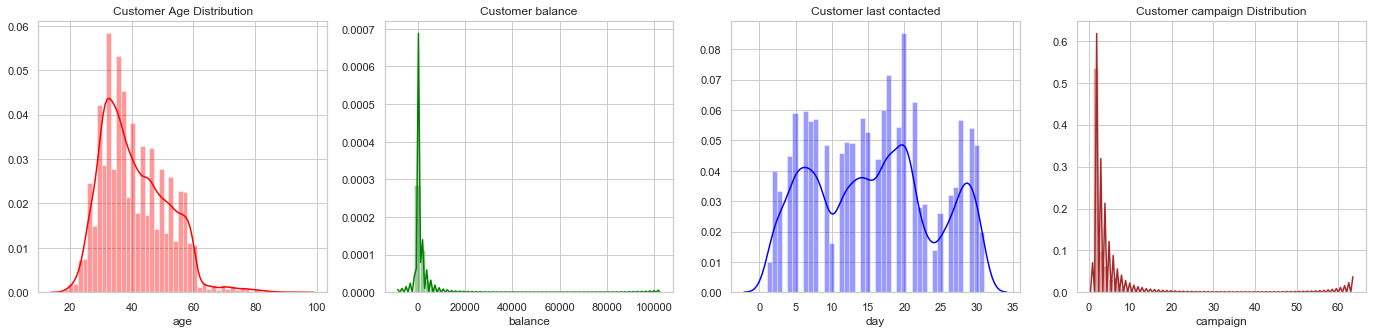

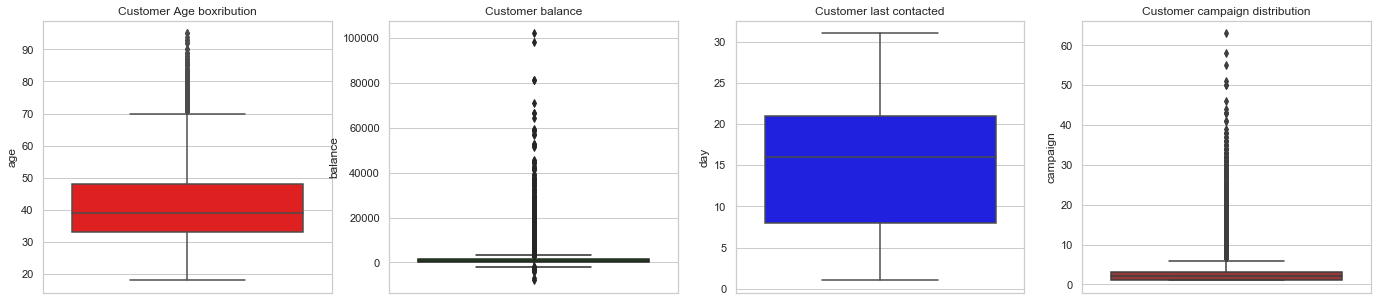

In [22]:
plt.figure(figsize=(30,5))
# subplot 1
plt.subplot(1, 5, 1)
plt.title('Customer Age Distribution')
sns.distplot(bank_df.age,color='Red')

# subplot 2
plt.subplot(1, 5, 2)
plt.title('Customer balance')
sns.distplot(bank_df.balance,color='green')

# subplot 3l
plt.subplot(1, 5, 3)
plt.title('Customer last contacted')
sns.distplot(bank_df.day,color='blue')

# subplot 4l
#plt.subplot(1, 5, 4)
#plt.title('Customer last conversation duration')
#sns.distplot(bank_df.duration,color='Orange')

# subplot 5l
plt.subplot(1, 5, 4)
plt.title('Customer campaign Distribution')
sns.distplot(bank_df.campaign,color='brown')


plt.figure(figsize=(30,5))
# subplot 1
plt.subplot(1, 5, 1)
plt.title('Customer Age boxribution')
sns.boxplot(bank_df.age,orient='vertical',color='Red')

# subplot 2
plt.subplot(1, 5, 2)
plt.title('Customer balance')
sns.boxplot(bank_df.balance,orient='vertical',color='green')

# subplot 3l
plt.subplot(1, 5, 3)
plt.title('Customer last contacted')
sns.boxplot(bank_df.day,orient='vertical',color='blue')

# subplot 4l
#plt.subplot(1, 5, 4)
#plt.title('Customer last conversation duration')
#sns.boxplot(bank_df.duration,orient='vertical',color='Orange')

# subplot 5l
plt.subplot(1, 5, 4)
plt.title('Customer campaign distribution')
sns.boxplot(bank_df.campaign,orient='vertical',color='brown')

Data is highly skewed and unbalanced. Further inferences to be followed post profiling.

<font color=Blue>
    
Alternatively, there is a pandas profling library which can be used to analyse each and every attribute in the given dataset.

In [143]:
import pandas_profiling
from pandas_profiling import ProfileReport

In [144]:
ProfileReport(bank_df)

##### Inferences:
* Below inferences obtained from pandas profiling aswell. 


<font color=Green>
    
Data set is higly unblanced dataset and all the variables seems to be weak learners based on the correlation values. Dataset has only 11.7% Target values with Yes.
1. Majority of the customers have between 20 and 60 years of age. Could be something to do with the retirement age.
2. balance has records with negative entries, it could be something to do with overdraft accounts/loan accounts. There are some outliers. , we will be trying to remove some outliers.
3. customer most contacted 20/21st of the month.
3. Majority of the customers are contacted through cellular phone.
4. 51% customers have Secondary education 
5. There are wide variety of jobs and out of all, blue collared jobs are high in dataset.
6. 60% are married in the given data.
7. Majority of customer contacts happened in the month of May.
8. Majority of previous outcome is unknown.
9. previous is highly skewed (γ1 = 41.846) Skewed
10. Dataset has 16 duplicate rows post removal of duration column. 

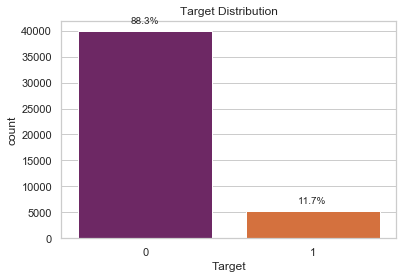

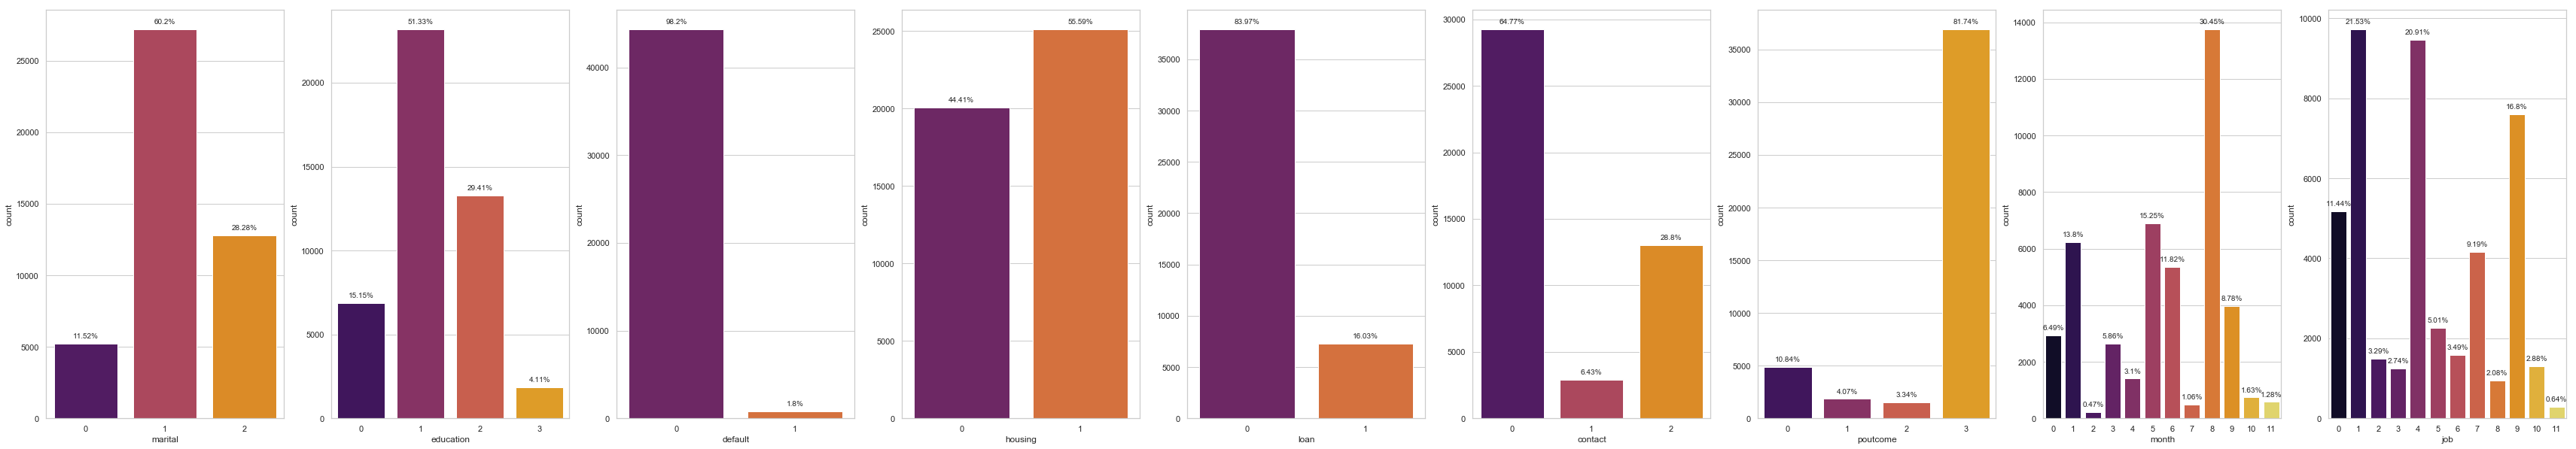

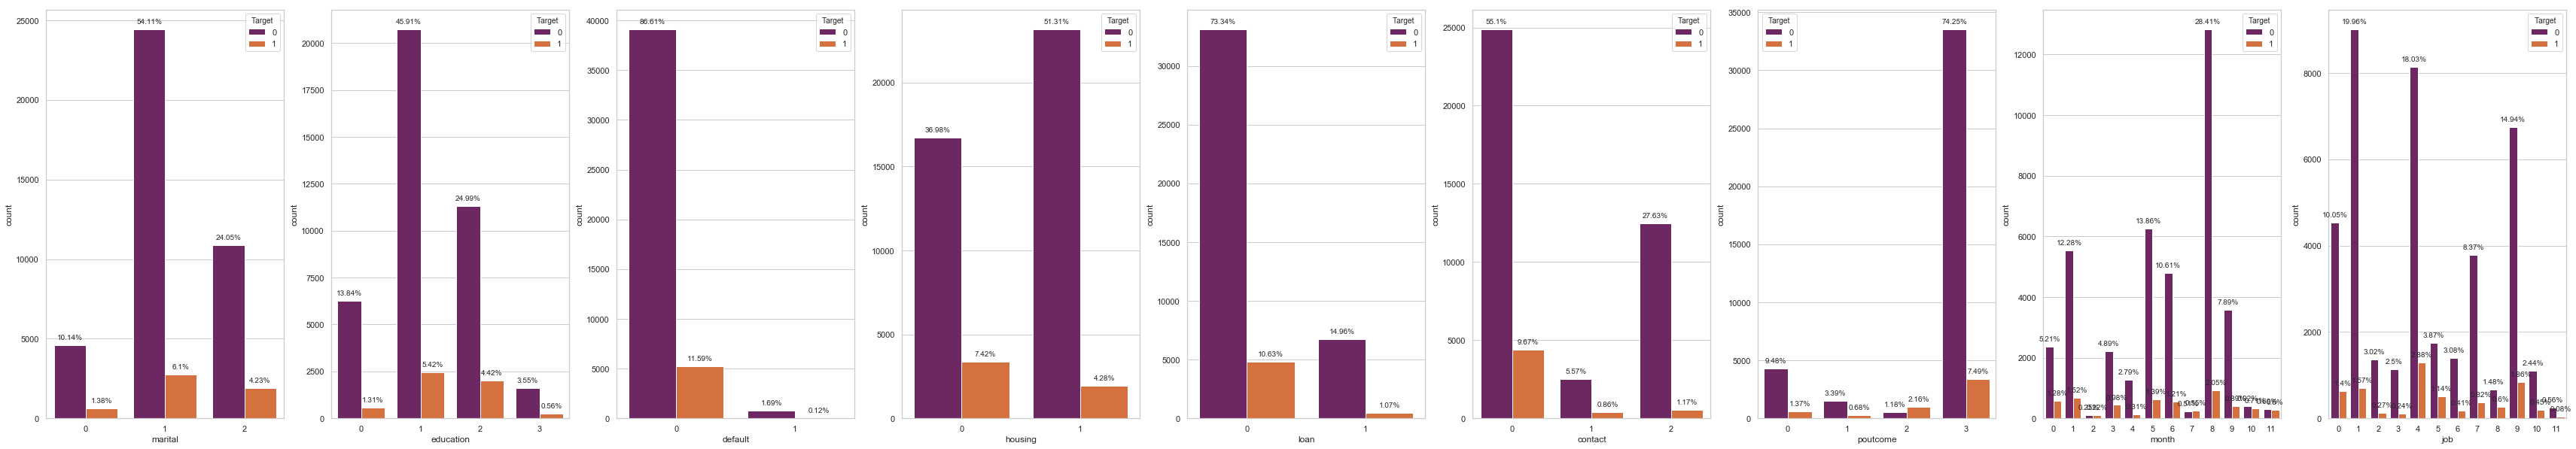

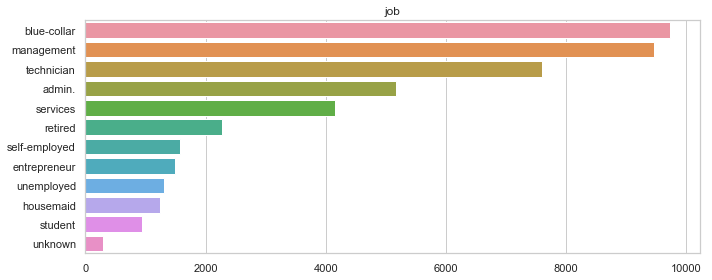

In [24]:
plt.title('Target Distribution')
ax=sns.countplot(data = bank_df, x= 'Target',palette='inferno') 
for p in ax.patches: 
    ax.annotate(str((np.round(p.get_height()/len(bank_df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

categorcial_variables = ['marital', 'education','default','housing','loan','contact','poutcome','month','job']

plt.figure(figsize=(60,10))
#categorcial_variables = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome','Target']
j = range(len(categorcial_variables))
for i in j:
    plt.subplot(1, 9, i+1)
    ax=sns.countplot(data = bank_df,palette='inferno', x= categorcial_variables[i]) 
    for p in ax.patches: 
        ax.annotate(str((np.round(p.get_height()/len(bank_df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.figure(figsize=(60,10))
#categorcial_variables = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome','Target']
p = range(len(categorcial_variables))
for i in p:
    plt.subplot(1, 9, i+1)
    ax=sns.countplot(data = bank_df, x= categorcial_variables[i],palette='inferno',hue = 'Target') 
    for p in ax.patches: 
        ax.annotate(str((np.round(p.get_height()/len(bank_df)*100,decimals=2)))+'%', (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.figure(figsize=(10,4))
sns.barplot(bank_df2['job'].value_counts().values, bank_df2['job'].value_counts().index)
plt.title('job')
plt.tight_layout()

##### Inferences:
* Below inferences obtained from pandas profiling aswell. 


<font color=Green>
    
1. Data set has a very less polutation where target is market to Yes. (only 11.7 %)
2. High number of Married members have opted for term deposit.
3. High number of members with secondary education opted for Term deposit.
4. Non defaulters have higher %of Term deposits.
5. Members with no house loan have the Term deposits.
6. Members who were contacted through Cellular phone holds more Term deposits.
7. Most people taken Term deposits in the month of May.
8. People in Management positions hold more term deposits.
9. In the given dataset, blue collar members are high in number. 
10. There seems to be drop in balance after 60 years.

#### Normalizing the Data

* Outliers <br>

Trying to remove the outliers of mortgage with IQR is not helpful as its removing the valid data. 
Hence some of the outliers are reduced with z score and beyond threshold of 3. We would be removing 745 rows with is close to 2% which is with in permissable limits. Morever we are not worried about balance outliers as current dataset is highly unbalanced and further removing data would impact the predictability of the model.

In [145]:
#import z statistic library
from scipy import stats

bank_df['balance_z'] = np.abs(stats.zscore(bank_df.balance))
bank_df=bank_df[bank_df.balance_z <3]

* Remove unwanted columns <br>
 Based on the above inferences we are dropping the unwanted columns

In [146]:
bank_df.drop('balance_z', axis = 1, inplace=True)

In [147]:
bank_df.shape

(44450, 16)

In [148]:
# correlation on the given dataset
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = bank_df.corr()
corr.style.background_gradient(cmap='coolwarm')

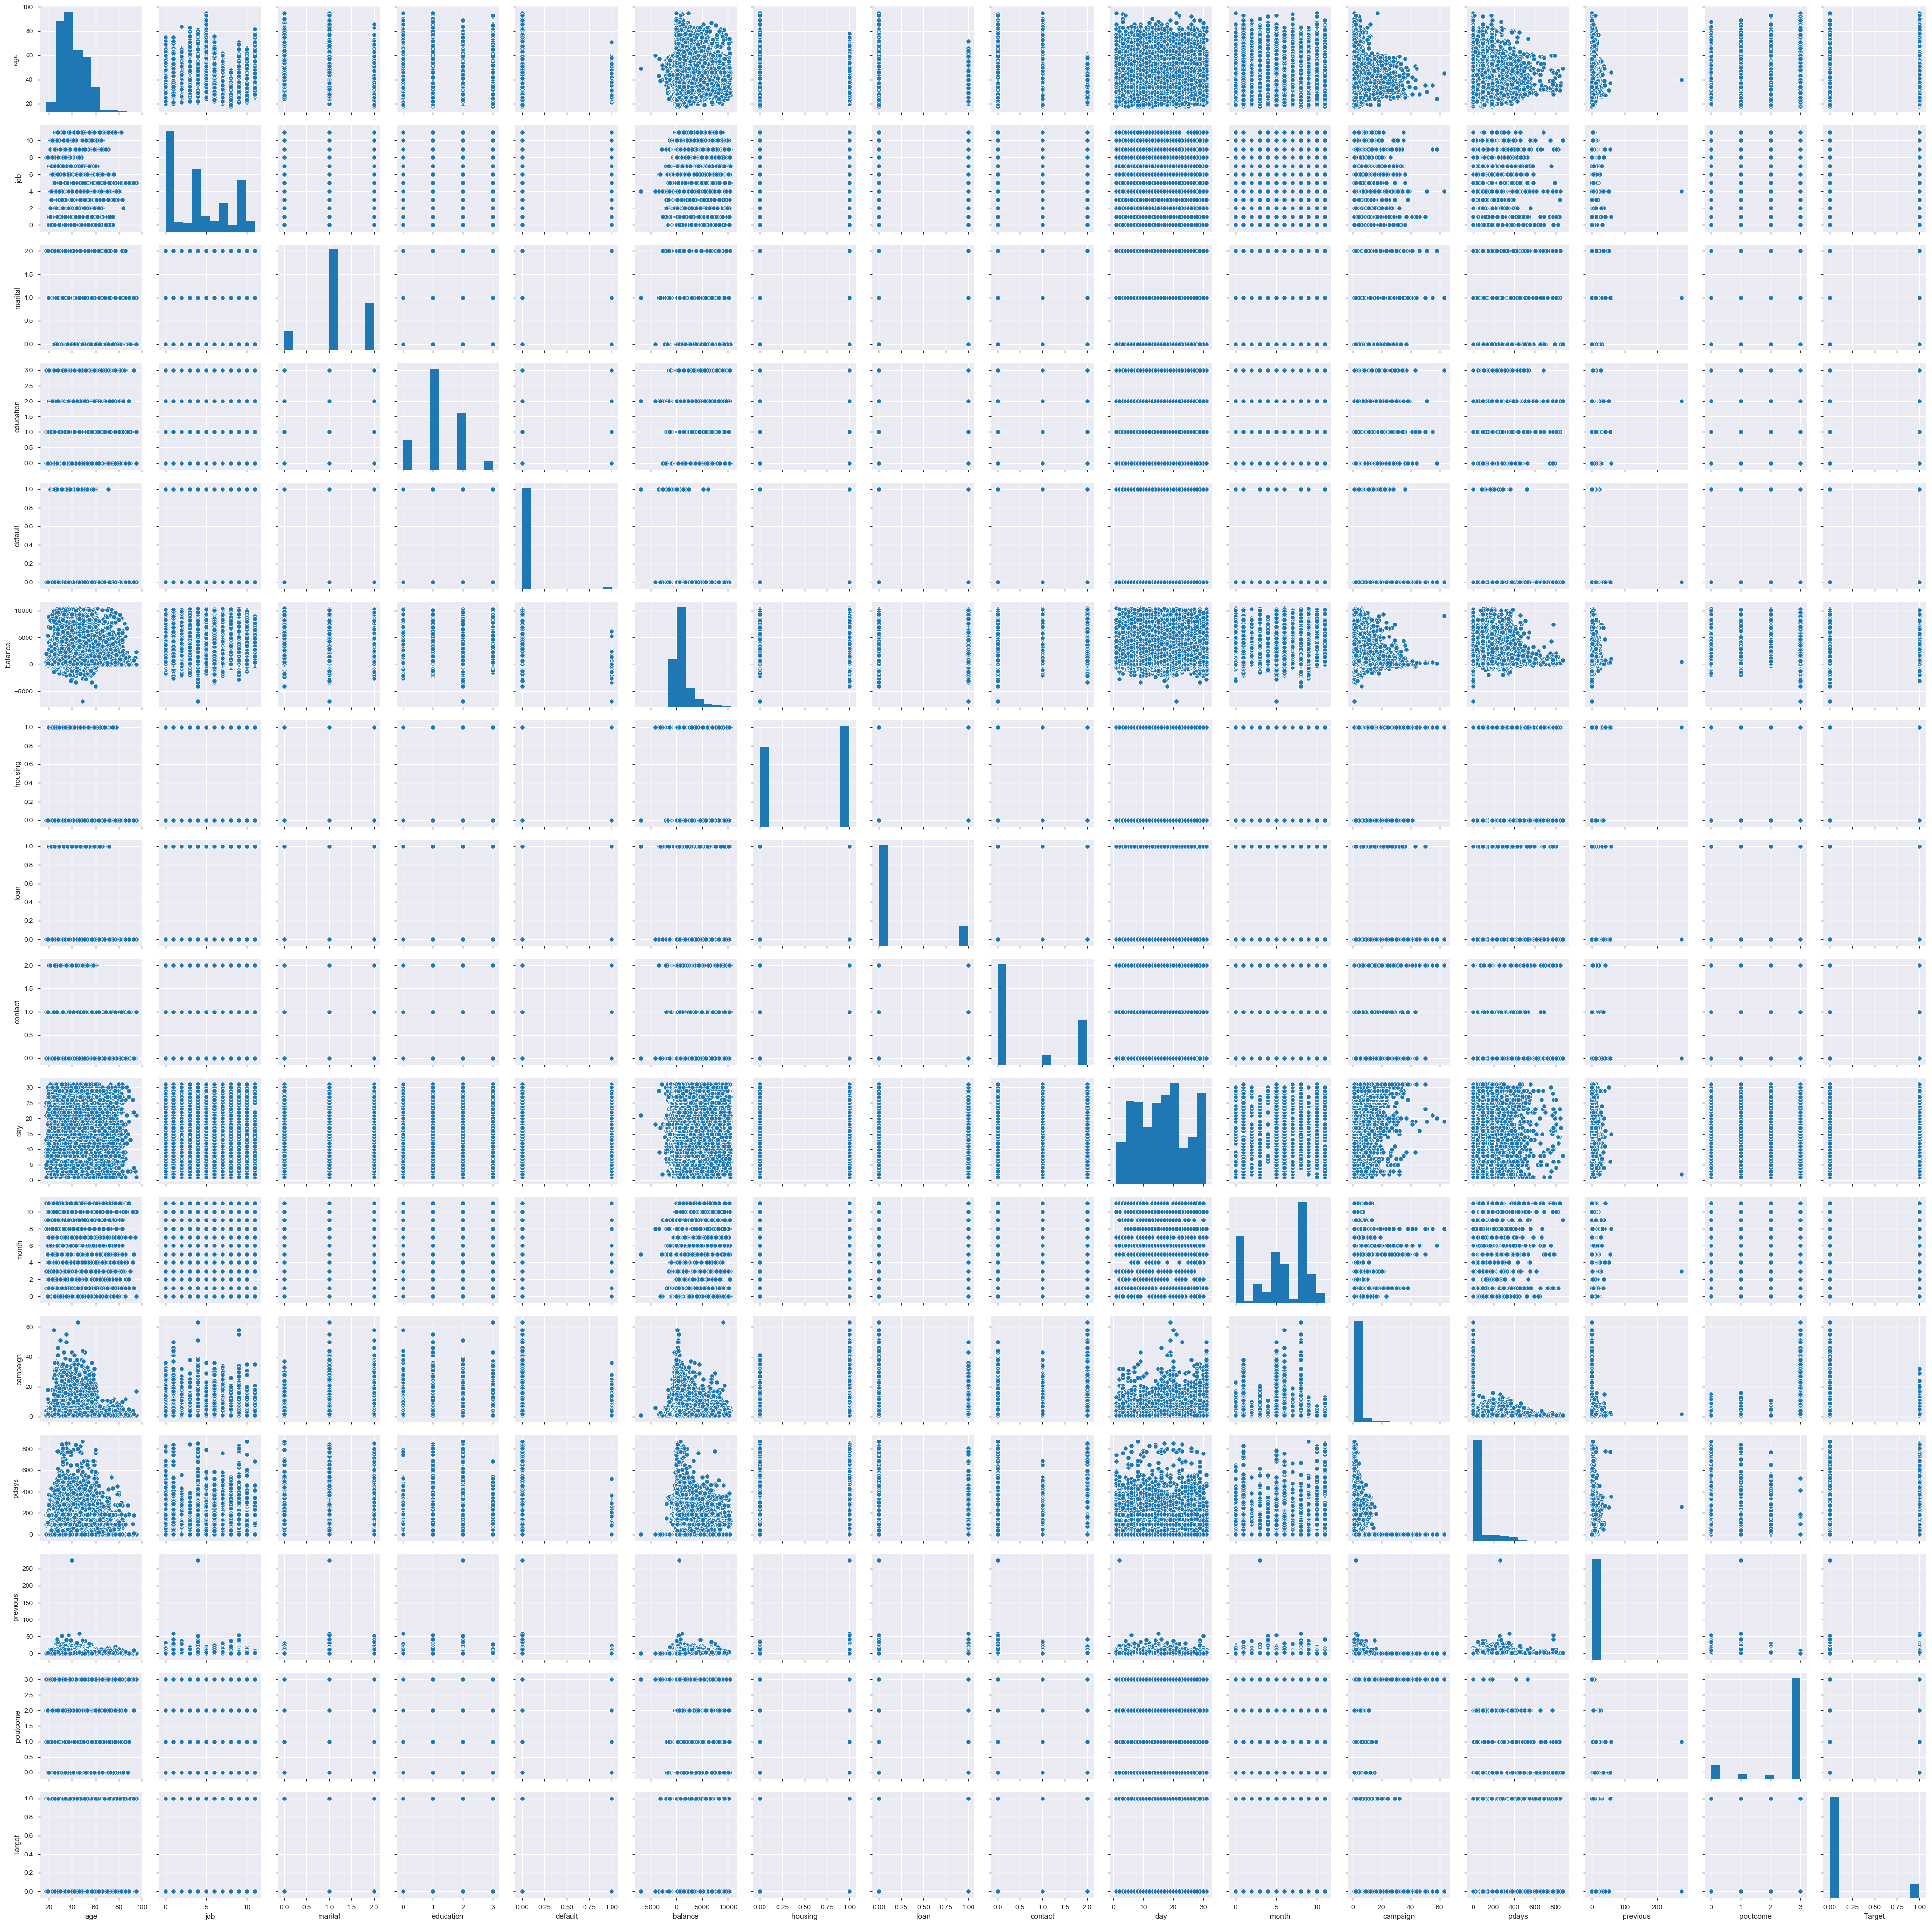

In [149]:
import seaborn as sns
sns.pairplot(bank_df)

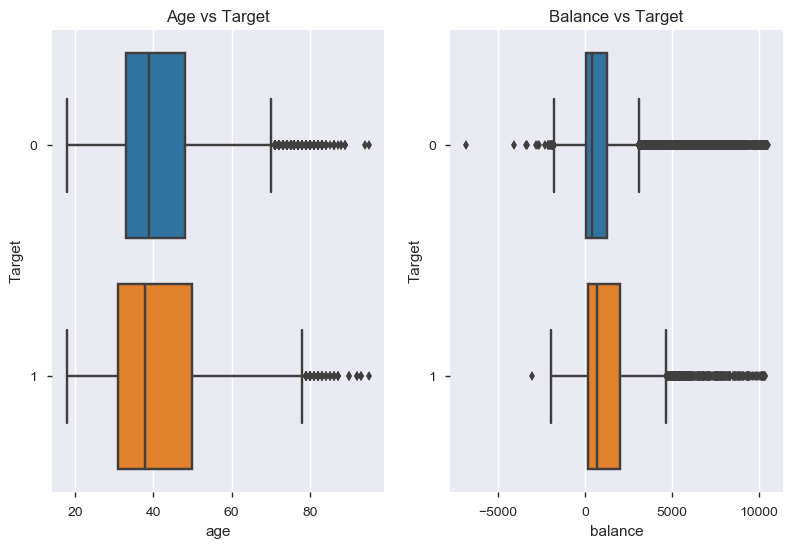

In [150]:
plt.figure(figsize=(30, 6))
plt.subplot(1,6,1)
#sns.jointplot(x = 'Income', y = 'CCAvg', data = loan_df,kind = 'kde')
#plt.subplot(1,4,2)
plt.title('Age vs Target')
sns.boxplot(x = 'age', y = 'Target',orient="horizontal",data = bank_df)
plt.subplot(1,6,2)
plt.title('Balance vs Target')
sns.boxplot(x = 'balance', y = 'Target',orient="horizontal", data = bank_df)

##### Inferences:

<font color= black>
    
Inspite of clearing the outliers, couldnt notice much improvement with the outliers and above correlation matrix suggests very weak relation.
Though we have weak learners we try to make use of them and try to use ensemble learning to improve the predictions.

<font color= Green>
    
Positively correlated columns    
* pdays
* previous
* balance
* education
* marital
* job
* age

<font color= Red>
   
Negatively correlated columns    
* default
* month
* day
* loan
* campaign
* poutcome
* housing
* contact


#### Split Target columns and Independendent columns 
Though columns have negative correlation and loosely corelated, we are not removing them as weak learners contribute for building decision trees and ensemble methods.

In [151]:
#Train and Test data split library import
from sklearn.model_selection import train_test_split 

In [152]:
X = bank_df.drop(['Target'],axis=1) # independant variables
y = bank_df['Target'] #Dependant variables

<font color=blue>
    
Split Data to 70:30 Train and Test ratio

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [154]:
print("Original Target True Values    : {0} ({1:0.2f}%)".format(len(bank_df.loc[bank_df['Target'] == 1]), (len(bank_df.loc[bank_df['Target'] == 1])/len(bank_df.index)) * 100))
print("Original Target False Values   : {0} ({1:0.2f}%)".format(len(bank_df.loc[bank_df['Target'] == 0]), (len(bank_df.loc[bank_df['Target'] == 0])/len(bank_df.index)) * 100))
print("")
print("Training Target True Values    : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), (len(y_train[y_train[:] == 1])/len(y_train)) * 100))
print("Training Target False Values   : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), (len(y_train[y_train[:] == 0])/len(y_train)) * 100))
print("")
print("Test Target True Values        : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), (len(y_test[y_test[:] == 1])/len(y_test)) * 100))
print("Test Target False Values       : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), (len(y_test[y_test[:] == 0])/len(y_test)) * 100))
print("")

Original Target True Values    : 5168 (11.63%)
Original Target False Values   : 39282 (88.37%)

Training Target True Values    : 3629 (11.66%)
Training Target False Values   : 27486 (88.34%)

Test Target True Values        : 1539 (11.54%)
Test Target False Values       : 11796 (88.46%)



### Lets predict using models!!

<font color=Red>
    
#### Logistic Regression

In [155]:
#Import required metrics libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Logistic regression model import
from sklearn.linear_model import LogisticRegression

#importing cross validation and Grid search library
from sklearn.model_selection import GridSearchCV


Hyper tuning parameters with the help of GridsearchCV

In [47]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
model=LogisticRegression(max_iter=50000)
model_cv=GridSearchCV(model,grid,cv=10)
model_cv.fit(X_train,y_train)

print("Tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("Accuracy :",model_cv.best_score_)

Tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'penalty': 'l2'}
Accuracy : 0.8824951687946638


In [156]:
# Fit the model with the help of hyper parameters

model2=LogisticRegression(C=1000,penalty="l2")
#model2=LogisticRegression()
model2.fit(X_train,y_train)


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [157]:
#predict on test
y_pred = model2.predict(X_test)

print('\033[91m' + "Logistic Regression Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Logistic Regression Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

log_df_cm = pd.DataFrame(mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
log_df_cm

#coef_df = pd.DataFrame(model.coef_)
#coef_df['intercept'] = model.intercept_
#print(coef_df)

Logistic Regression Stats
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     11796
           1       0.27      0.00      0.00      1539

    accuracy                           0.88     13335
   macro avg       0.58      0.50      0.47     13335
weighted avg       0.81      0.88      0.83     13335

Recall :  0.0
Accuracy :  0.88
Precision :  0.27
Logistic Regression Confusion Matrix


Predict 1  Predict 0
1          3       1536
0          8      11788

ROC/AUC Curve

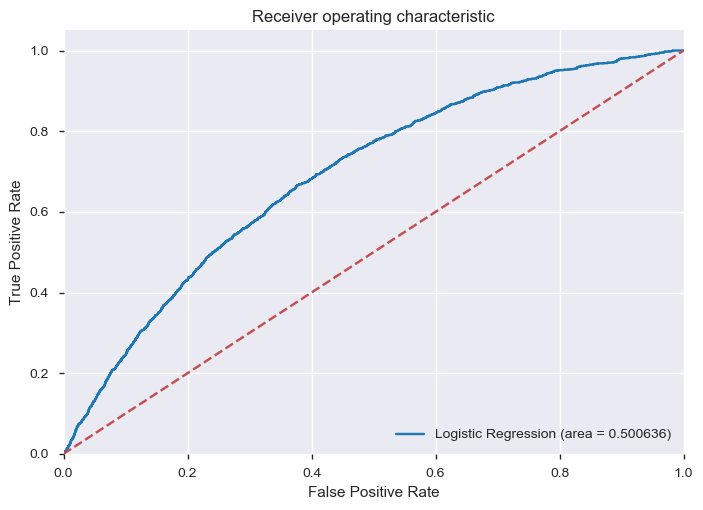

In [158]:
log_roc_auc = roc_auc_score(y_test, model2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %02f)' % log_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<font color=Red>
    
#### Naive Bayes

In [159]:
# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB

In [160]:
nb_clf = GaussianNB()
NB_result = nb_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [161]:
y_pred = nb_clf.predict(X_test)

print('\033[91m' + "Naive Bayes Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Naive Bayes Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
nv_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

nv_df_cm = pd.DataFrame(nv_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
nv_df_cm

Naive Bayes Stats
              precision    recall  f1-score   support

           0       0.91      0.86      0.89     11796
           1       0.25      0.35      0.29      1539

    accuracy                           0.80     13335
   macro avg       0.58      0.61      0.59     13335
weighted avg       0.83      0.80      0.82     13335

Recall :  0.35
Accuracy :  0.8
Precision :  0.25
Naive Bayes Confusion Matrix


Predict 1  Predict 0
1        542        997
0       1619      10177

ROC/AUC Curve

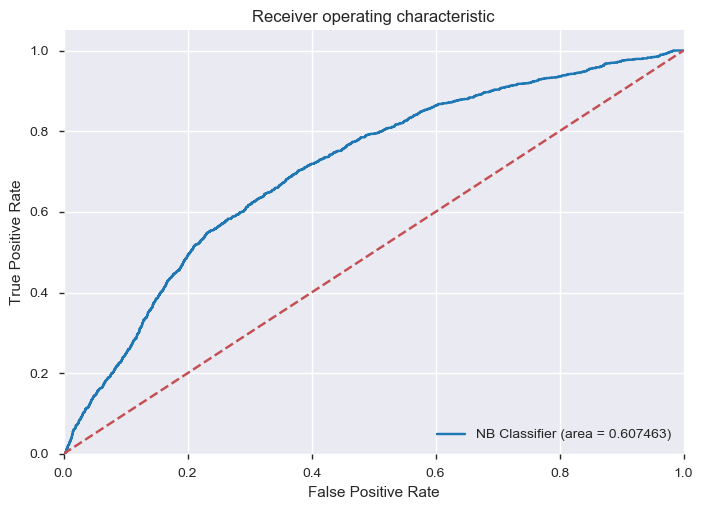

In [163]:
NB_roc_auc = roc_auc_score(y_test,nb_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, nb_clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='NB Classifier (area = %2f)' % NB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

<font color=Red>
    
#### KNN-Classification
<font color=black>
    
With KNN we deal with neighbouring data points. There is no specific criteria to choose the K value. Generally we start with neighbours of 3,5,7 etc., However when calculate accuracy score is reducing when calculated with 5 and 7. Hence we have confined to the test with k = 3.

In [164]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

In [165]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors = 3)

# fitting the model
knn.fit(X_train, y_train)
# predict the response
y_pred = knn.predict(X_test)


In [166]:
print('\033[91m' + "KNN Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "KNN Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
knn_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

knn_df_cm = pd.DataFrame(knn_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
knn_df_cm

KNN Stats
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     11796
           1       0.33      0.14      0.20      1539

    accuracy                           0.87     13335
   macro avg       0.61      0.55      0.56     13335
weighted avg       0.83      0.87      0.84     13335

Recall :  0.14
Accuracy :  0.87
Precision :  0.33
KNN Confusion Matrix


Predict 1  Predict 0
1        220       1319
0        442      11354

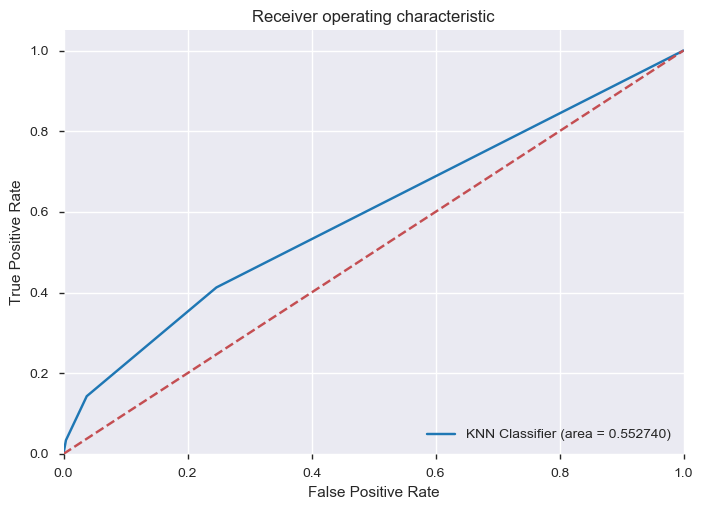

In [167]:
KNN_roc_auc = roc_auc_score(y_test,knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='KNN Classifier (area = %2f)' % KNN_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NB_ROC')
plt.show()

<font color=Red>
    
#### Decision Tree
<font color=black>
    

In [168]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

In [169]:
from graphviz import Source

In [170]:
dTree = DecisionTreeClassifier(criterion = 'entropy')
dTree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [171]:
print(dTree.score(X_train, y_train))
print(dTree.score(X_test, y_test))

1.0
0.833970753655793


Decisions trees are prone to overfit as in this case. Hence we implement pruning of branches. Lets see that further in regularization

In [172]:
train_char_label = ['1', '0']
Credit_Tree_File = open('credit_tree.dot','w')
dot_data = tree.export_graphviz(dTree, out_file=Credit_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))
Credit_Tree_File.close()

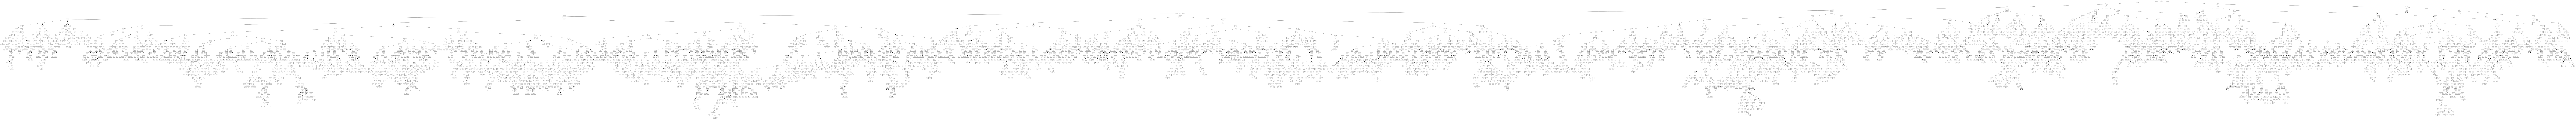

In [174]:
retCode = system("dot -Tpng credit_tree.dot -o credit_tree.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_tree.png"))



In [204]:
    # importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(dTree.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values("Imp", ascending= False))

                Imp
balance    0.236831
age        0.148846
day        0.127088
month      0.087488
campaign   0.068933
job        0.067702
pdays      0.061334
contact    0.044555
poutcome   0.042421
education  0.037424
housing    0.024167
marital    0.022563
loan       0.014049
previous   0.014037
default    0.002561


In [176]:
y_pred = dTree.predict(X_test)

print('\033[91m' + "Decision Tree Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Decision Tree Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
dt_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

dt_df_cm = pd.DataFrame(dt_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
dt_df_cm

Decision Tree Stats
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     11796
           1       0.30      0.33      0.32      1539

    accuracy                           0.83     13335
   macro avg       0.61      0.62      0.61     13335
weighted avg       0.84      0.83      0.84     13335

Recall :  0.33
Accuracy :  0.83
Precision :  0.3
Decision Tree Confusion Matrix


Predict 1  Predict 0
1        514       1025
0       1189      10607

ROC/AUC Curve

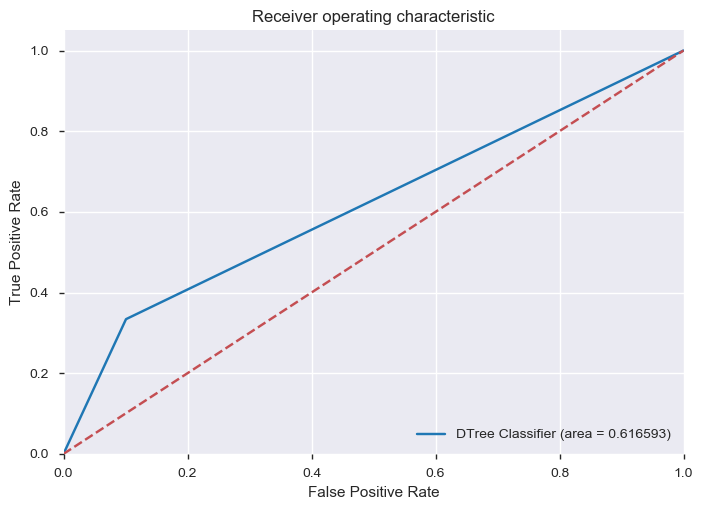

In [177]:
DT_roc_auc = roc_auc_score(y_test,dTree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dTree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DTree Classifier (area = %2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

<font color=Red>
    
#### Regularized Decision Tree
<font color=black>
    
Lets restrict the depth to 7 and rerun decision tree

In [178]:
reg_dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
reg_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [206]:
print(reg_dt_model.score(X_train, y_train))
print(reg_dt_model.score(X_test, y_test))

0.8966414912421662
0.8948631421072366


In [207]:
train_char_label = ['1', '0']
reg_dt_model_File = open('reg_dt_model.dot','w')
dot_data = tree.export_graphviz(reg_dt_model, out_file=reg_dt_model_File, feature_names = list(X_train), class_names = list(train_char_label))
reg_dt_model_File.close()

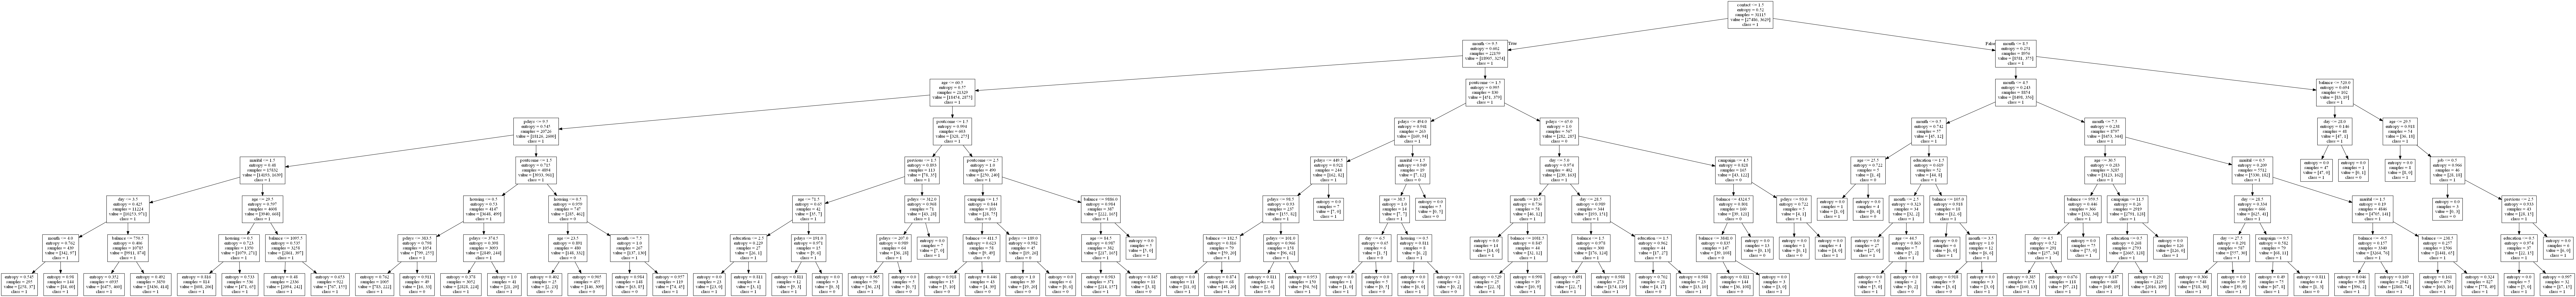

In [208]:
retCode = system("dot -Tpng reg_dt_model.dot -o reg_dt_model_File.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("reg_dt_model_File.png"))

In [205]:
    # importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(reg_dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values("Imp", ascending= False))

                Imp
poutcome   0.212633
contact    0.199041
month      0.154775
age        0.120007
pdays      0.116148
housing    0.061687
balance    0.046497
marital    0.036825
day        0.031762
campaign   0.008774
education  0.007323
previous   0.003061
job        0.001466
default    0.000000
loan       0.000000


In [214]:
y_pred = reg_dt_model.predict(X_test)

print('\033[91m' + "Regularized Decision Tree Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Regularized Decision Tree Confusion Matrix" + '\033[0m')
#print(confusion_matrix(Regularized y_test,y_pred))
reg_dt_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

reg_dt_df_cm = pd.DataFrame(reg_dt_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
reg_dt_df_cm

Regularized Decision Tree Stats
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11796
           1       0.66      0.18      0.29      1539

    accuracy                           0.89     13335
   macro avg       0.78      0.59      0.61     13335
weighted avg       0.87      0.89      0.87     13335

Recall :  0.18
Accuracy :  0.89
Precision :  0.66
Regularized Decision Tree Confusion Matrix


Predict 1  Predict 0
1        281       1258
0        144      11652

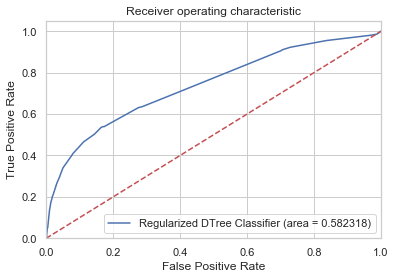

In [44]:
DT_roc_auc = roc_auc_score(y_test,reg_dt_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, reg_dt_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Regularized DTree Classifier (area = %2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right")
plt.savefig('Reg_DT_ROC')
plt.show()

<font color=Red>
    
#### Ensemble Learning - Bagging
<font color=black>
    
Bagging with the decision tree as base model    

In [184]:
from sklearn.ensemble import BaggingClassifier

bgcl = BaggingClassifier(base_estimator=dTree, n_estimators=50)

#bgcl = BaggingClassifier(n_estimators=50)
bgcl = bgcl.fit(X_train, y_train)

In [185]:
print(bgcl.score(X_train, y_train))
print(bgcl.score(X_test, y_test))

0.9993250843644544
0.8948631421072366


In [186]:
y_pred = bgcl.predict(X_test)

print('\033[91m' + "Bagging Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Bagging Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
bagg_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

bagg_mcm_df_cm = pd.DataFrame(bagg_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
bagg_mcm_df_cm

Bagging Stats
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11796
           1       0.61      0.25      0.35      1539

    accuracy                           0.89     13335
   macro avg       0.76      0.61      0.65     13335
weighted avg       0.87      0.89      0.87     13335

Recall :  0.25
Accuracy :  0.89
Precision :  0.61
Bagging Confusion Matrix


Predict 1  Predict 0
1        382       1157
0        245      11551

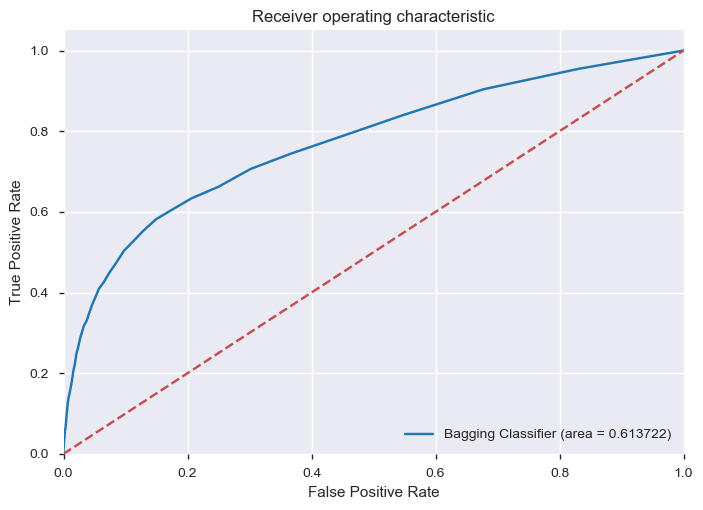

In [187]:
bgcl_roc_auc = roc_auc_score(y_test,bgcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, bgcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Bagging Classifier (area = %2f)' % bgcl_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right")
plt.savefig('bgcl_ROC')
plt.show()

<font color=Red>
    
#### Ensemble Learning - AdaBoosting
<font color=black>
    

In [213]:
from sklearn.ensemble import AdaBoostClassifier
abcl = AdaBoostClassifier(base_estimator=dTree, n_estimators=10)
#abcl = AdaBoostClassifier( n_estimators=50)
abcl = abcl.fit(X_train, y_train)

In [189]:
print(abcl.score(X_train, y_train))
print(abcl.score(X_test, y_test))

1.0
0.8372703412073491


In [191]:
y_pred = abcl.predict(X_test)

print('\033[91m' + "Adaboost Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Adaboost Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
abcl_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

abcl_mcm_df_cm = pd.DataFrame(abcl_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
abcl_mcm_df_cm

Adaboost Stats
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     11796
           1       0.31      0.33      0.32      1539

    accuracy                           0.84     13335
   macro avg       0.61      0.62      0.61     13335
weighted avg       0.84      0.84      0.84     13335

Recall :  0.33
Accuracy :  0.84
Precision :  0.31
Adaboost Confusion Matrix


Predict 1  Predict 0
1        511       1028
0       1142      10654

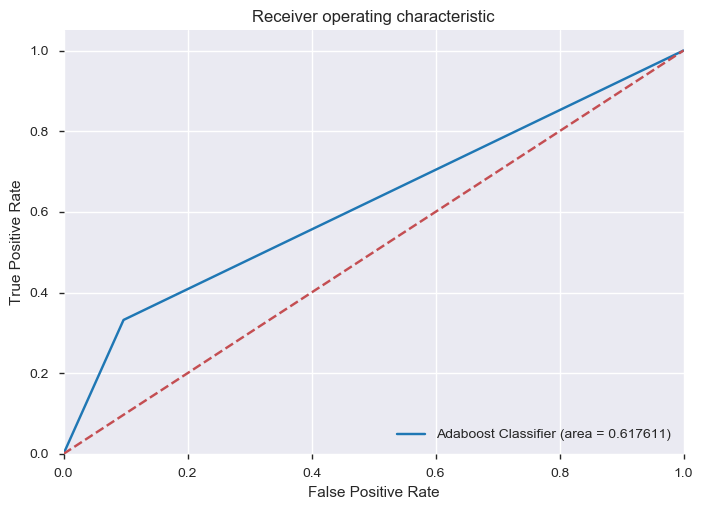

In [192]:
abcl_roc_auc = roc_auc_score(y_test,abcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, abcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Adaboost Classifier (area = %2f)' % abcl_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right")
plt.savefig('abcl_ROC')
plt.show()

<font color=Red>
    
#### Ensemble Learning - GradientBoost
<font color=black>
    

In [203]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50)
gbcl = gbcl.fit(X_train, y_train)

In [194]:
print(gbcl.score(X_train, y_train))
print(gbcl.score(X_test, y_test))

0.8934276072633778
0.8943382077240345


In [195]:
y_pred = gbcl.predict(X_test)

print('\033[91m' + "Gradient Boost Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Gradient Boost Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
gbcl_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

gbcl_mcm_df_cm = pd.DataFrame(gbcl_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
gbcl_mcm_df_cm

Gradient Boost Stats
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11796
           1       0.69      0.15      0.25      1539

    accuracy                           0.89     13335
   macro avg       0.80      0.57      0.60     13335
weighted avg       0.88      0.89      0.86     13335

Recall :  0.15
Accuracy :  0.89
Precision :  0.69
Decision Tree Confusion Matrix


Predict 1  Predict 0
1        233       1306
0        103      11693

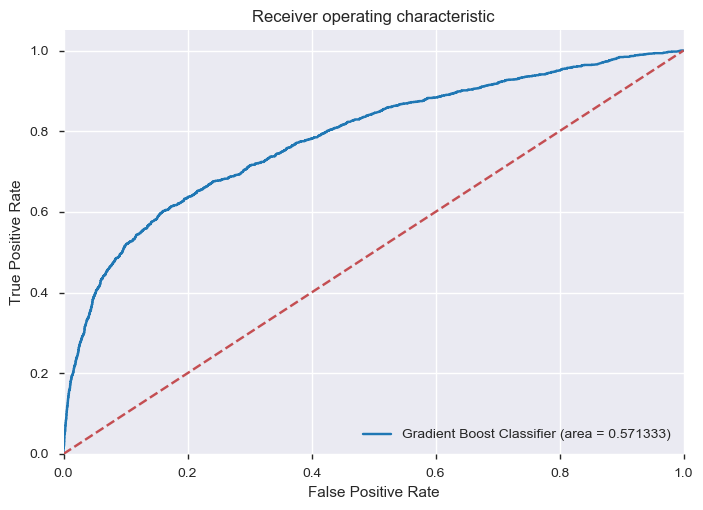

In [196]:
GB_roc_auc = roc_auc_score(y_test,gbcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, gbcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boost Classifier (area = %2f)' % GB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right")
plt.savefig('GB_ROC')
plt.show()

<font color=Red>
    
#### Ensemble Learning - RandomForest
<font color=black>
       

In [199]:
from sklearn.ensemble import RandomForestClassifier
rfcl = RandomForestClassifier(n_estimators = 50)
rfcl = rfcl.fit(X_train, y_train)

In [200]:
print(rfcl.score(X_train, y_train))
print(rfcl.score(X_test, y_test))

0.9991643901655151
0.8936632920884889


In [201]:
y_pred = rfcl.predict(X_test)

print('\033[91m' + "Random Forest Stats" + '\033[0m')
print(classification_report(y_test,y_pred))
print("Recall : ",round(recall_score(y_test,y_pred),2))
print("Accuracy : ",round(accuracy_score(y_test,y_pred),2))
print("Precision : ",round(precision_score(y_test,y_pred),2))

print('\033[91m' + "Random Forest Confusion Matrix" + '\033[0m')
#print(confusion_matrix(y_test,y_pred))
rfcl_mcm=confusion_matrix(y_test, y_pred, labels=[1, 0])

rfcl_mcm_df_cm = pd.DataFrame(rfcl_mcm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
rfcl_mcm_df_cm

Random Forest Stats
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     11796
           1       0.61      0.21      0.31      1539

    accuracy                           0.89     13335
   macro avg       0.76      0.60      0.63     13335
weighted avg       0.87      0.89      0.87     13335

Recall :  0.21
Accuracy :  0.89
Precision :  0.61
Random Forest Confusion Matrix


Predict 1  Predict 0
1        325       1214
0        204      11592

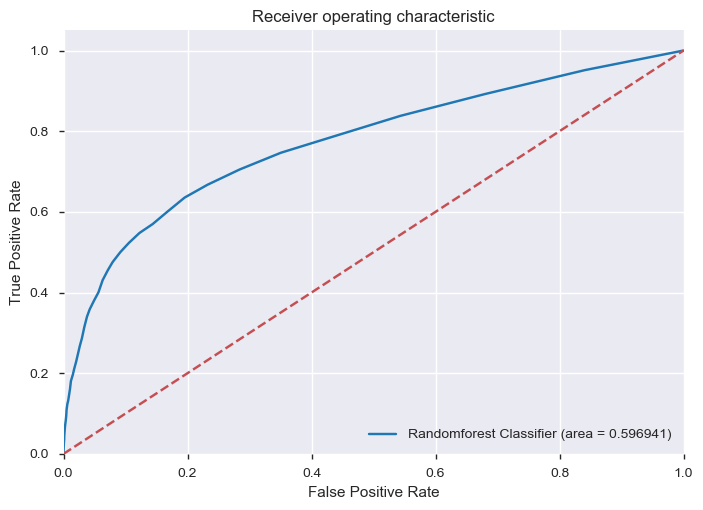

In [202]:
RF_roc_auc = roc_auc_score(y_test,rfcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Randomforest Classifier (area = %2f)' % RF_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic') 
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

<font color=Red>
    
### Conclusions:

Dataset is highly unbalanced and have very weak relation between the features. As we are restricting it to ensemble methods, none of the weakly correlated were excluded. This can be further performed in the feature selection in PCA/LDA techniques. Recall values are as well very low however we have obtained better results with ensemble learning.

Based on ROC/AUC curve below is the order of model performance based on False Negatives and Recall values. <br>

<font color=Blue>
    
Adboosting with decision tree (Recall= .33) > Bagging with decison tree (Recall = .25) > Regularized decision tree with the depth of 7(Recall = 0.18)

However there is still scope in improving this with the help of feature selection.